# Use Amazon Bedrock (Titan Multimodal Embedding) and Amazon OpenSearch Service to build a contextual text and image search engine for product recommendations

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
!pip install opensearch-py
!pip install requests-aws4auth
!pip install -U boto3
!pip install -U botocore
!pip install -U awscli

In [ ]:
# restart kernel
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

This notebook aims at building a prototyping a Large Language Model (LLM) powered search engine POC to retrieve and recommend products based on text or image queries. This is a step-by-step guide on how to use [Amazon Bedrock Titan models](https://aws.amazon.com/bedrock/titan) to encode images and text into embeddings, ingest embeddings into [Amazon OpenSearch Service](https://aws.amazon.com/opensearch-service/) index, and query the index using OpenSearch Service [k-nearest neighbors (KNN) functionality](https://docs.aws.amazon.com/opensearch-service/latest/developerguide/knn.html).

## 1. Data overview and preparation

It's recommended to execute the notebook in SageMaker Studio Notebooks `Python 3.0(Data Science)` Kernel with `ml.t3.medium` instance.

**Warning** ⚠️ If you don't have an OpenSearch cluster running, you need to use the CloudFormation template to create one for you.

Install some python packages we are going to use in the POC.

In [2]:
import boto3
import pandas as pd
import os
import re
import boto3
import json
import base64
import numpy as np
import seaborn as sns
from PIL import Image
from io import BytesIO


from tqdm import tqdm
from urllib.parse import urlparse
from multiprocessing.pool import ThreadPool

from utils import *

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [ ]:
# getting boto3 clients for required AWS services
sts_client = boto3.client('sts')
s3_client = boto3.client('s3')

bedrock_client = boto3.client(
    "bedrock-runtime", 
    "us-east-1", 
    endpoint_url="https://bedrock-runtime.us-east-1.amazonaws.com"
)

In [ ]:
session = boto3.session.Session()
region = session.region_name
account_id = sts_client.get_caller_identity()["Account"]
region, account_id

## 2. Load publically available dataset

Load the metadata

In [ ]:
meta = pd.read_json("s3://amazon-berkeley-objects/listings/metadata/listings_0.json.gz", lines=True)
def func_(x):
    us_texts = [item["value"] for item in x if item["language_tag"] == "en_US"]
    return us_texts[0] if us_texts else None

meta = meta.assign(item_name_in_en_us=meta.item_name.apply(func_))
meta = meta[~meta.item_name_in_en_us.isna()][["item_id", "item_name_in_en_us", "main_image_id"]]
print(f"#products with US English title: {len(meta)}")
meta.head()

You should be able to see over 1600 products in the data frame.
Next, you can link the item names with item images. `images/metadata/images.csv.gz` contains Image metadata. This file is a gzip-compressed comma-separated value (CSV) file with the following columns: `image_id`, `height`, `width`, and `path`. You can read the meta data file and then merge it with item metadata.

In [ ]:
image_meta = pd.read_csv("s3://amazon-berkeley-objects/images/metadata/images.csv.gz")
dataset = meta.merge(image_meta, left_on="main_image_id", right_on="image_id")

In [ ]:
# Create a new column in dataset with FULL PATH of the image
dataset = dataset.assign(img_full_path=f's3://amazon-berkeley-objects/images/small/' + dataset.path.astype(str))
dataset

You can have a look at one sample image from the dataset by running the following code

In [ ]:
image, item_name = get_image_from_item_id_s3(item_id = "B0896LJNLH", dataset = dataset, image_path = f's3://amazon-berkeley-objects/images/small/' )
print(item_name)
image

## 3. Generate embedding from item images

Amazon Titan Multimodal Embeddings G1 Generation 1 (G1) is able to project both images and text into the same latent space, so we only need to encode item images or texts into embedding space. In this practice, you can use [batch inference](https://docs.aws.amazon.com/bedrock/latest/userguide/batch-inference.html) to encode item images. Before creating the job, you need to copy item images from Amazon Berkeley Objects Dataset public S3 bucket to your own S3 Bucket. The operation needs take less than 10 mins.

But for this notebook, we'll use reak-time API than batch inference.

In [ ]:
%%time
multimodal_embeddings_img = []

for idx, path in enumerate(dataset['img_full_path']):
    embedding = get_titan_multimodal_embedding(image_path=path, dimension=1024)["embedding"]
    multimodal_embeddings_img.append(embedding)

dataset = dataset.assign(embedding_img=multimodal_embeddings_img)

In [ ]:
dataset.head()

### 3.1 Visualize the Image Embedding

In [ ]:
plot_similarity_heatmap(multimodal_embeddings_img[:20], multimodal_embeddings_img[:20])

In [ ]:
# Store dataset
dataset.to_csv('dataset.csv', index = False)

In [3]:
from ast import literal_eval
dataset = pd.read_csv('dataset.csv')
dataset.shape, dataset.columns

((1649, 9),
 Index(['item_id', 'item_name_in_en_us', 'main_image_id', 'image_id', 'height',
        'width', 'path', 'img_full_path', 'embedding_img'],
       dtype='object'))

In [6]:
dataset.dtypes

item_id               object
item_name_in_en_us    object
main_image_id         object
image_id              object
height                 int64
width                  int64
path                  object
img_full_path         object
embedding_img         object
dtype: object

In [7]:
# Convert embedding_img and embedding_desc column to a list
# dataset.loc[:,'embedding_img'] = dataset.loc[:,'embedding_img'].apply(lambda x: literal_eval(x))

## 4. Load OpenSearch Service

Next we will define the `opensearch_region` and `opensearch_url`, we will use our CloudFormation Stack Name to fetch the OpenSearch Domain URL. 

**Note1** If you didn't use the CloudFormation template provided in the repo to create the cluster.  You can skip the following cell and define your own `opensearch_region` and `opensearch_region`.  
**Note2** If your SageMaker Execution role doesn't have permission to describe CloudFormation Stack.  You can go the CloudFormation service in AWS Console, and use the output of `clip-poc-stack` to config these two parameters.

In [8]:
import boto3

client = boto3.client('cloudformation')

response = client.describe_stacks(
    StackName='test-titan-image-poc',
)

my_session = boto3.session.Session()

opensearch_region = my_session.region_name
opensearch_url = [
    output_["OutputValue"]
    for output_ in response["Stacks"][0]["Outputs"]
    if output_["OutputKey"] == "DomainEndpoint"
][0]

print(opensearch_url)

search-os-titan-img-poc-byrwz7kyjoozrtidpuljvinz2e.us-east-1.es.amazonaws.com


### 4.1 Setting up the Amazon OpenSearch Service domain using KNN settings

First, set up an OpenSearch service cluster. For instructions, see [Creating and Managing Amazon OpenSearch Service Domains](https://docs.aws.amazon.com/opensearch-service/latest/developerguide/createupdatedomains.html).   
Once the OpenSearch cluster is set up, create an index to store the item meta data and the embeddings. The index settings must be configured beforehand to enable the KNN functionality using the following configuration:

In [9]:
index_settings = {
  "settings": {
    "index.knn": True,
    "index.knn.space_type": "cosinesimil"
  },
  "mappings": {
    "properties": {
      "embeddings": {
        "type": "knn_vector",
        "dimension": 1024 #Make sure this is the size of the embeddings you generated, for RN50, it is 1024
      }
    }
  }
}

This example uses the Python Elasticsearch client to communicate with the Elasticsearch cluster and create an index to host our data.

In [12]:
import boto3
import json
# from requests_aws4auth import AWS4Auth
# from elasticsearch import Elasticsearch, RequestsHttpConnection
from opensearchpy import OpenSearch, RequestsHttpConnection
from requests_aws4auth import AWS4Auth

index_name = 'titan-poc-index'
opensearch_region = 'us-east-1'
service = 'es'

def get_es_client(host=opensearch_url,
        port=443,
        region=opensearch_region,
        index_name=index_name
    ):

    credentials = boto3.Session().get_credentials()
    awsauth = AWS4Auth(credentials.access_key,
                       credentials.secret_key,
                       region,
                       service,
                       session_token=credentials.token)

    headers = {"Content-Type": "application/json"}

    es = OpenSearch(hosts=[{'host': host, 'port': port}],
                       http_auth=awsauth,
                       use_ssl=True,
                       verify_certs=True,
                       connection_class=RequestsHttpConnection,
                       timeout=60 # for connection timeout errors
    )
    return es


In [14]:
es = get_es_client()
es.indices.create(index=index_name, body=json.dumps(index_settings))

# You can check if the index is created within your es cluster
print(es.indices.get_alias("*"))

{'titan-poc-index1': {'aliases': {}}, '.plugins-ml-config': {'aliases': {}}, '.opensearch-observability': {'aliases': {}}, '.ql-datasources': {'aliases': {}}, '.opensearch-sap-log-types-config': {'aliases': {}}, 'image_index': {'aliases': {}}, 'titan-poc-index': {'aliases': {}}, '.kibana_2': {'aliases': {'.kibana': {}}}, '.kibana_1': {'aliases': {}}}


In [13]:
# deleting indices
# es.indices.delete(index=index_name)

{'acknowledged': True}

Next you need to loop through your dataset and ingest items data into the cluster. A more robust and scalable solution for the embedding ingestion can be found in [Ingesting enriched data into Amazon ES](https://aws.amazon.com/blogs/industries/novartis-ag-uses-amazon-elasticsearch-k-nearest-neighbor-knn-and-amazon-sagemaker-to-power-search-and-recommendation/). The data ingestion for this POC should finish within 60 seconds. It also executes a simple query to verify the data have been ingested into the index.

In [23]:
import tqdm.notebook as tq

# ingest_data_into_es

for idx, record in tq.tqdm(dataset.iterrows(), total=len(dataset)):
    body = record[['item_name_in_en_us']].to_dict()
    body['embeddings'] = dataset['embedding_img'][idx]
    es.index(index=index_name, id=record.item_id, body=body)

#Check that data is indeed in ES
res = es.search(
    index=index_name, body={
        "query": {
                "match_all": {}
    }},
    size=2)
assert len(res["hits"]["hits"]) > 0

  0%|          | 0/1649 [00:00<?, ?it/s]

## 5. Perform a real-time Multimodal Searching

Now that you have a working OpenSearch index to contain embeddings for your inventory, let's have a look at how you can generate embedding for new items. You'll use Amazon Titan Multimodal Embeddings G1 Generation 1 (G1) extracting text features and image features. 

Let’s take a look at the results of a simple query. After retrieving results from the OpenSearch service, we get the item names and images from dataset.

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


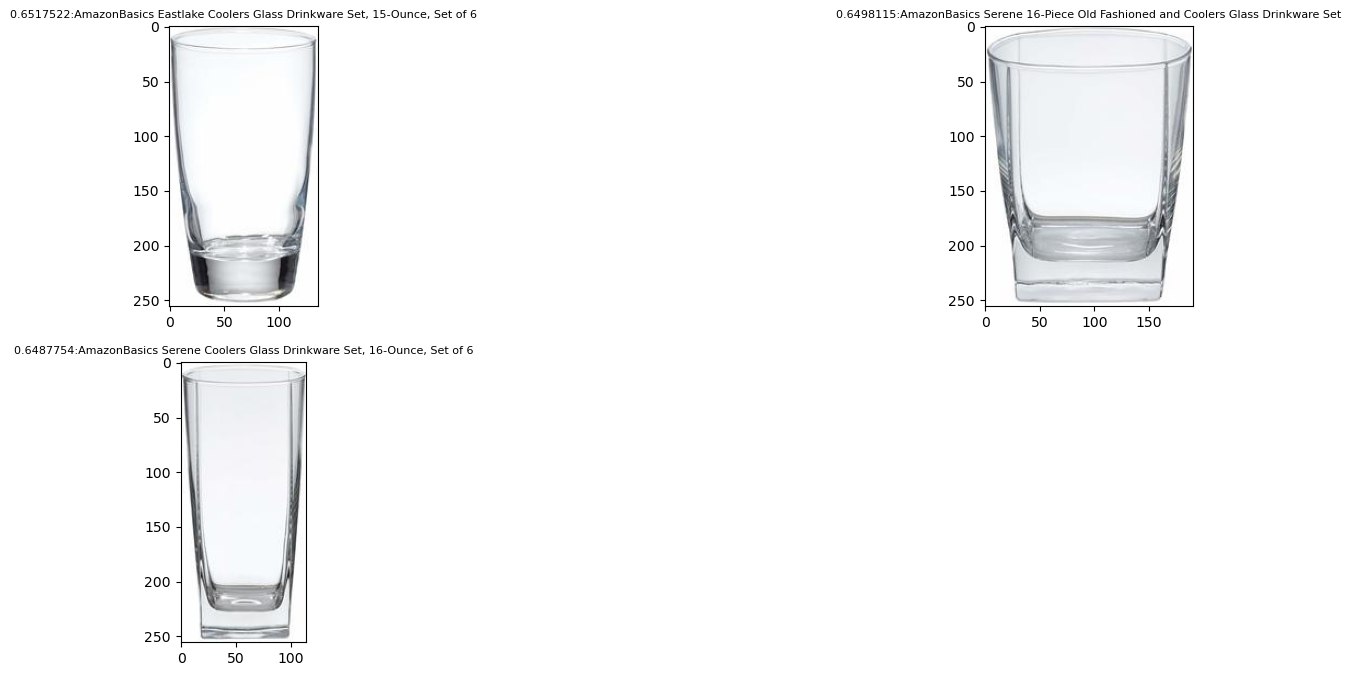

In [26]:
query_prompt = "drinkware glass"

similar_items = find_similar_items(query_prompt = query_prompt, k=5, num_results=3, index_name=index_name, dataset = dataset, 
                                   open_search_client = es, image_path=f's3://amazon-berkeley-objects/images/small/')

display_images(similar_items)

## 6. Cleaning up

With Amazon Bedrock, On-demand pricing plan,is a cost-effective option for testing the POC/prototyping. When you finish this exercise, remove your resources with the following steps:

Delete SageMaker Studio user profile and domain.  
Optionally, empty and delete the S3 bucket, or keep whatever you want.  

In [ ]:
es.indices.delete(index=index_name, ignore=[400, 404])
# !rm -rf data/